Building pre-trained LSTM model (shear stress prediction) for Transfer learning on p5271 experiment

In [ ]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from keras.utils import plot_model
import time
import tensorflow as tf


In [ ]:
# Function to create data with timesteps

def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)):
		end_ix = i + n_steps
		if end_ix > len(data):
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix-1, -1]  #last column is the target variable
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)
 

In [ ]:
# Load the data

data = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_ML_Master.mat')
m_t = pd.DataFrame({'Time':data['Time'].ravel().round(2), 'SS':data['SS'].ravel()})
a_t = pd.DataFrame({'Time':data['LocalAcTime'].ravel().round(2), 'V_filt':data['V_filt'].ravel(), 'Vel_pc':data['Vel_pc'].ravel(),
                    'A_filt':data['A_filt'].ravel(), 'T_pc':data['T_pc'].ravel()})  
df1 = a_t.merge(m_t, on='Time')

df = df1.drop(['Time'], axis=1)   # Drop irrelevant features
print("Input data:\n", df)


Input data:
              V_filt  Vel_pc       A_filt  T_pc        SS
0       5489.978529     0.0  1804.180000   0.0  5.656166
1       5489.981454     0.0  1803.666667   0.0  5.657157
2       5489.997639     0.0  1803.314286   0.0  5.658317
3       5490.007016     0.0  1803.437500   0.0  5.659499
4       5490.000189     0.0  1803.266667   0.0  5.660404
...             ...     ...          ...   ...       ...
132394  5459.380488     0.0  1784.250000   0.0  5.471059
132395  5459.377762     0.0  1784.055556   0.0  5.474545
132396  5459.388352     0.0  1783.837500   0.0  5.478286
132397  5459.398820     0.0  1783.371429   0.0  5.481751
132398  5459.399041     0.0  1781.433333   0.0  5.484813

[132399 rows x 5 columns]


In [ ]:
# Preprocessing

arr = df.to_numpy()
n_steps = 60
xdf, ydf = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape, Y = ', np.shape(ydf))


Features shape, X =  (132340, 60, 4)
Target shape, Y =  (132340,)


In [ ]:
# Split into train-val-test
x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, shuffle=False)
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=False)

# Normalize the features
scaler = MinMaxScaler()
num_instances, num_time_steps, num_features = X_train.shape
X_train = scaler.fit_transform(np.reshape(X_train, (-1, num_features)))
X_train = np.reshape(X_train, (num_instances, num_time_steps, num_features))

num_instances, num_time_steps, num_features = X_val.shape
X_val = scaler.transform(np.reshape(X_val, (-1, num_features)))
X_val = np.reshape(X_val, (num_instances, num_time_steps, num_features))

num_instances, num_time_steps, num_features = x_test.shape
x_test = scaler.transform(np.reshape(x_test, (-1, num_features)))
x_test = np.reshape(x_test, (num_instances, num_time_steps, num_features))

print("Training:", np.shape(X_train))
print("Validation:", np.shape(X_val))
print("Testing:", np.shape(x_test))


Training: (95284, 60, 4)
Validation: (10588, 60, 4)
Testing: (26468, 60, 4)


Epoch 1/10
2978/2978 [==============================] - 257s 86ms/step - loss: 13.2739 - val_loss: 0.0021
Epoch 2/10
2978/2978 [==============================] - 259s 87ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 3/10
2978/2978 [==============================] - 261s 88ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 4/10
2978/2978 [==============================] - 259s 87ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 5/10
2978/2978 [==============================] - 261s 87ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 6/10
2978/2978 [==============================] - 260s 87ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 7/10
2978/2978 [==============================] - 261s 88ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 8/10
2978/2978 [==============================] - 259s 87ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 9/10
2978/2978 [==============================] - 260s 87ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 10/10
2978/2978 [==============================]

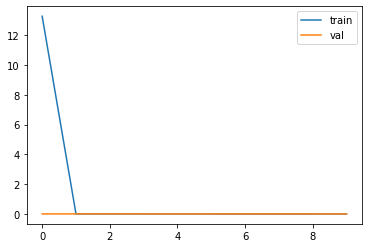

---Training time: 2600.58699560 seconds ---


In [ ]:
# Build the model

np.random.seed(0)   # To get reproducible results
tf.random.set_seed(1)

model = Sequential()
model.add(LSTM(128, activation='relu', kernel_initializer='normal', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(64, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='relu'))
model.compile(loss='mse', optimizer='adam')

start_time = time.time()
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_val, Y_val), verbose=1)
end_time = time.time()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

print("---Training time: %0.8f seconds ---" % (end_time - start_time))


In [ ]:
# Save the model

print(model.summary())
plot_model(model, show_shapes=True)
model.save('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/models/LSTM_t1_ss.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               68096     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 76,417
Trainable params: 76,417
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Evaluate the model

y_predTrain = model.predict(X_train)
train_r2 = r2_score(Y_train, y_predTrain)
train_rmse = np.sqrt(mean_squared_error(Y_train, y_predTrain))

y_predVal = model.predict(X_val)
val_r2 = r2_score(Y_val, y_predVal)
val_rmse = np.sqrt(mean_squared_error(Y_val, y_predVal))  

start_time = time.time()
y_predTest = model.predict(x_test)
end_time = time.time()

test_r2 = r2_score(y_test, y_predTest)
test_rmse = np.sqrt(mean_squared_error(y_test, y_predTest))

print("R2 scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(train_r2, val_r2, test_r2))
print("RMSE scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(train_rmse, val_rmse, test_rmse))

print("\n---Time for Test data prediction: %0.8f seconds ---" % (end_time - start_time))

R2 scores: Train - 0.93477, Validation - 0.95423, Test - 0.92095
RMSE scores: Train - 0.03283, Validation - 0.03132, Test - 0.04071

---Time for Test data prediction: 5.85661173 seconds ---


Text(0.5, 1.0, 'Shear Stress prediction using LSTM model')

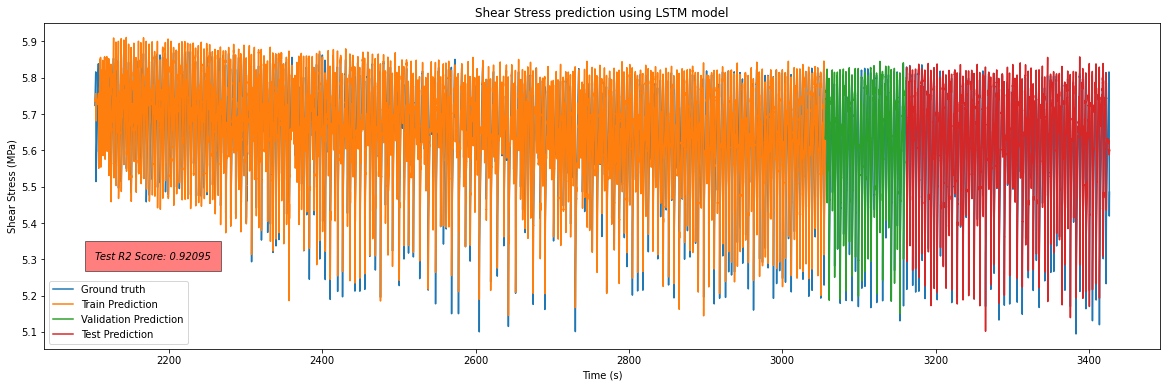

In [ ]:
# Overall plot

ttime = df1['Time'][n_steps-1:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.1, shuffle=False)

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf)
plt.plot(traintime, y_predTrain)
plt.plot(valtime, y_predVal)
plt.plot(testtime, y_predTest)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.text(ttime.iloc[0], 5.3, 'Test R2 Score: %0.5f' %(test_r2), style='italic', bbox=dict(facecolor='red', alpha=0.5, pad=10))
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])
plt.title('Shear Stress prediction using LSTM model')


Text(0.5, 1.0, 'Detailed View, Testing Data')

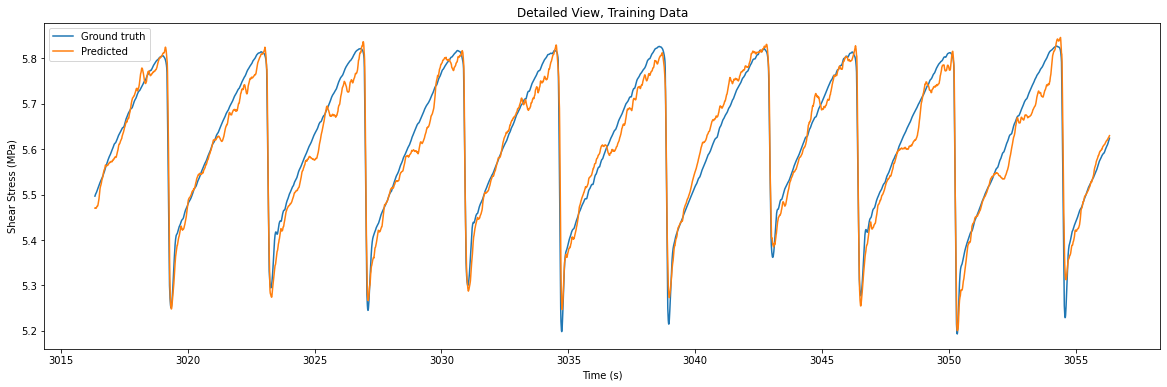

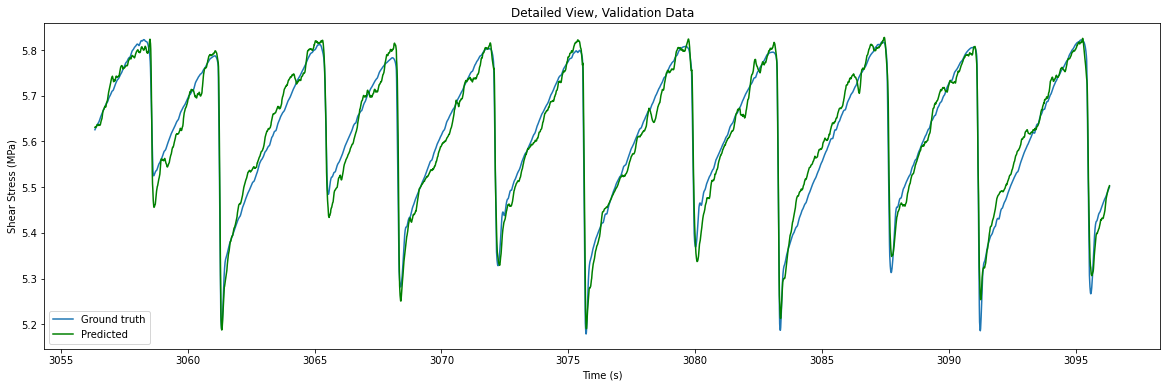

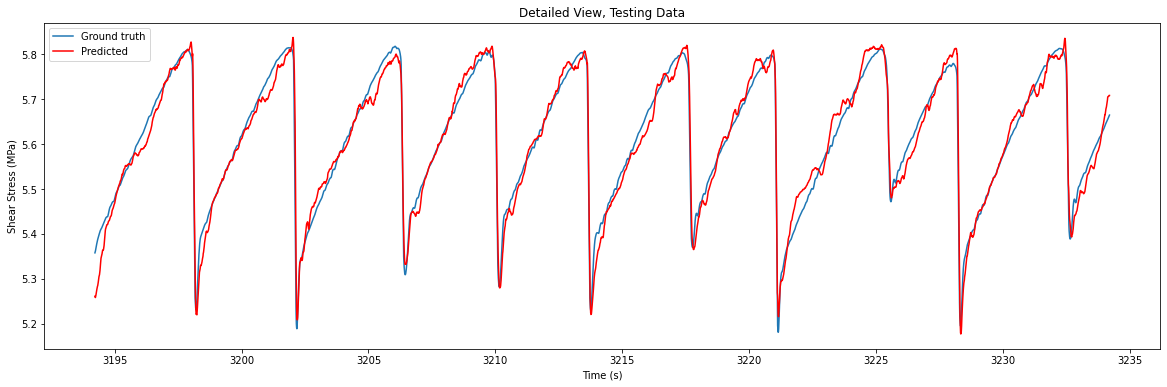

In [ ]:
# Detailed view of the plots

n=4000

fig = plt.figure(4, figsize=(20,6))
plt.plot(traintime[-n:], Y_train[-n:])
plt.plot(traintime[-n:], y_predTrain[-n:])
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Training Data')

fig = plt.figure(5, figsize=(20,6))
plt.plot(valtime[:n], Y_val[:n])
plt.plot(valtime[:n], y_predVal[:n], 'g')
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Validation Data')

st_i = 3200
fig = plt.figure(6, figsize=(20,6))
plt.plot(testtime[st_i:st_i+n], y_test[st_i:st_i+n])
plt.plot(testtime[st_i:st_i+n], y_predTest[st_i:st_i+n], 'r')
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Testing Data')
